****Importing our libraries****

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

**Visualization of Dataset**

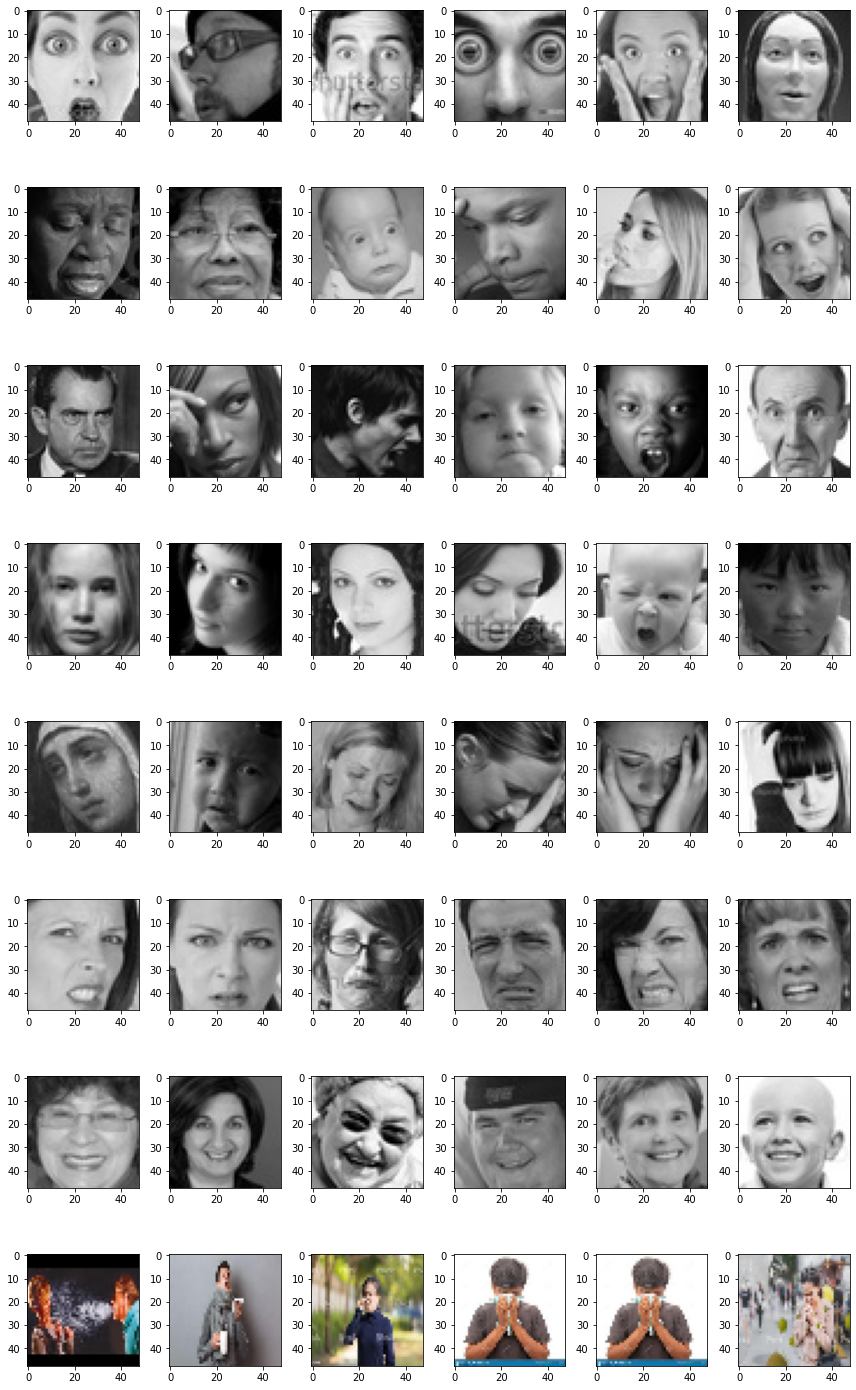

In [3]:
# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path ="/kaggle/input/private-dataset/images/"

plt.figure(0, figsize=(12,20))
cpt = 0
for expression in os.listdir(base_path + "train/"):
    for i in range(1,7):
        cpt = cpt + 1
        plt.subplot(8,6,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

**Generating Train and Validation Dataset**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "test",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

**Defining our CNN Architecture**

In [ ]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 8

# Initialising the CNN
model = Sequential()
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 5th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(nb_classes, activation='softmax'))
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

**Training our Model**

In [ ]:
from keras.callbacks import ModelCheckpoint
epochs = 40


checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

In [ ]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save_weights("model_weights.h5")
print("Saved model to disk")

In [ ]:
objects = ('angry','disgust','fear','happy','neutral','sad','sneezing and coughing','surprise')
y_pos = np.arange(len(objects))
print(y_pos)

In [ ]:
def emotion_analysis(emotions):
    objects = ['angry','disgust','fear','happy','neutral','sad','sneezing and coughing','surprise']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [ ]:
from keras.preprocessing import image

**Real Time Prediction of Model**

In [ ]:
from skimage import io
img = image.load_img('../input/facetesting/sneeze-facts-0-1492360561.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/facetesting/sneeze-facts-0-1492360561.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

# x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()
m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [ ]:
from skimage import io
img = image.load_img('../input/facetesting/Sneeze.jfif', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/facetesting/Sneeze.jfif', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

# x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()
m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [ ]:
from skimage import io
img = image.load_img('../input/facetesting/angry human face20210307-220702-122581.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/facetesting/angry human face20210307-220702-122581.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

# x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()
m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [ ]:
from skimage import io
img = image.load_img('../input/private-dataset/images/train/happy/Training_10070997.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/private-dataset/images/train/happy/Training_10070997.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

# x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()
m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [ ]:
from skimage import io
img = image.load_img('../input/private-dataset/images/train/sneezing and coughing/sneezing and coughing face20210307-213022-312662.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/private-dataset/images/train/sneezing and coughing/sneezing and coughing face20210307-213022-312662.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

# x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()
m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [ ]:
from skimage import io
img = image.load_img('../input/private-dataset/images/train/sad/Training_10111384.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/private-dataset/images/train/sad/Training_10111384.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

# x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()
m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [ ]:
from skimage import io
img = image.load_img('../input/private-dataset/images/train/fear/Training_10110501.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/private-dataset/images/train/fear/Training_10110501.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

# x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()
m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [ ]:
from skimage import io
img = image.load_img('../input/facetesting/Photo.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('../input/facetesting/Photo.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

# x /= 255

custom = model.predict(x)
print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()
m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [ ]:
# from skimage import io
# img = image.load_img('../input/facetesting/Sneeze.jfif', grayscale=True, target_size=(48, 48))
# show_img=image.load_img('../input/facetesting/Sneeze.jfif', grayscale=False, target_size=(200, 200))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis = 0)

# x /= 255

# custom = model.predict(x)
# print(custom[0])

In [ ]:
# from skimage import io
# img = image.load_img('../input/facetesting/sneeze-facts-0-1492360561.jpg', grayscale=True, target_size=(48, 48))
# show_img=image.load_img('../input/facetesting/sneeze-facts-0-1492360561.jpg', grayscale=False, target_size=(200, 200))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis = 0)

# # x /= 255

# custom = model.predict(x)
# print(custom[0])

In [ ]:
# objects = ('sneezing and coughing','angry', 'disgust', 'fear', 'happy', 'sad')
# y_pos = np.arange(len(objects))
# print(y_pos)

In [ ]:
# from skimage import io
# img = image.load_img('../input/facetesting/sneeze-facts-0-1492360561.jpg', grayscale=True, target_size=(48, 48))
# show_img=image.load_img('../input/facetesting/sneeze-facts-0-1492360561.jpg', grayscale=False, target_size=(200, 200))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis = 0)

# # x /= 255

# custom = model.predict(x)
# print(custom[0])

In [ ]:
# from skimage import io
# img = image.load_img('../input/facetesting/portrait-attractive-cheerful-young-man-smiling-happy-face-human-expressions-emotions-model-beautiful-smile-blue-eyes-147751681.jpg', grayscale=True, target_size=(48, 48))
# show_img=image.load_img('../input/facetesting/portrait-attractive-cheerful-young-man-smiling-happy-face-human-expressions-emotions-model-beautiful-smile-blue-eyes-147751681.jpg', grayscale=False, target_size=(200, 200))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis = 0)

# # x /= 255

# custom = model.predict(x)
# print(custom[0])

In [ ]:
# from skimage import io
# img = image.load_img('../input/private-dataset/images/test/fear/PrivateTest_10153550.jpg', grayscale=True, target_size=(48, 48))
# show_img=image.load_img('../input/private-dataset/images/test/fear/PrivateTest_10153550.jpg', grayscale=False, target_size=(200, 200))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis = 0)

# # x /= 255

# custom = model.predict(x)
# #print(custom[0])
# emotion_analysis(custom[0])

# x = np.array(x, 'float32')
# x = x.reshape([48, 48]);

# plt.gray()
# plt.imshow(show_img)
# plt.show()
# m=0.000000000000000000001
# a=custom[0]
# for i in range(0,len(a)):
#     if a[i]>m:
#         m=a[i]
#         ind=i
        
# print('Expression Prediction:',objects[ind])

In [ ]:
from keras.models import model_from_json

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [ ]:
# # load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")
 

In [ ]:
# opt = Adam(lr=0.001)
# loaded_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# from tensorflow.keras.preprocessing import image

In [ ]:
# img_path = "../input/facetesting/sneeze-facts-0-1492360561.jpg"
# # plt.imshow(img)
# # plt.show()

In [ ]:
# img = image.load_img(img_path)

In [ ]:
# model.predict_classes(img)

**Analyzing our Model**

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()  